In [1]:
import os
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product
import time

In [49]:
pd.set_option('display.float_format', lambda x: '%.1e' % x)

In [3]:
notebooks_base = os.environ["NOTEBOOKS"]
ms_base = os.path.join(notebooks_base, 'bit/ms/')

# Abstract

This notebook outlines the process for performing systematic search over the high dimensional parameter space of the MAPK model to determine the robustness of the parameters to imprecise measurement. A search grid is built and Bertini is called with python's multiprocessing and subprocess modules.

# Method

In [4]:
def parse_bertini_main_data(fl):
    """
    This function parses a MAIN_DATA file from Bertini
    :param fl: file object object
    :return: list of solutions
    """
    it = (line.strip() for line in fl)
    number_variables = next(it)
    solution_dimension = int(number_variables[21:])
    variables = next(it)
    rank = next(it)
    _ = next(it)
    dimension_title = next(it)
    _ = next(it)
    non_singular_title = next(it)
    
    line = next(it)
    solns = []
    while line == '---------------':
        path_number = next(it)
        component_number = next(it)
        estimated_condition_number = next(it)
       
        components = []
        for i in range(solution_dimension):
            component = next(it)

            re, im = component.split(' ')
            component = float(re) + 1j * float(im)
            components.append(component)
        solns.append(components)
        
        multiplicity = next(it)
        deflations = next(it)
        line = next(it)
    return solns

In [5]:
def triage_solns(solns):
    """
    This function takes a list of complex ring solution vectors and identifies biologically feasible ones.
    Biologically feasible solutions are real and nonnegative.
    """
    
    keep = []
    for soln in solns:
        soln = np.array(soln)
        re = np.real(soln)
        im = np.imag(soln)
        if np.allclose(np.zeros(shape=im.shape), im) and np.all(re >= 0):            
            keep.append(re)        
    
    return np.array(keep)

The following parameters were chosen to perterb because they only had one digit of precision. This could have been due to difficulty in experimental precision. Many of these values are also powers of 10, so they might only be estimations of orders of magnitude. A logarithmic search space is built within 1 log in each direction around each parameters' original value.

In [52]:
parameters_to_mod = 'k1', 'k2', 'k3', 'k5', 'k8', 'k10', 'k11', 'k12', 'k13', 'k17', 'k18'
print(', '.join(parameters_to_mod))

k1, k2, k3, k5, k8, k10, k11, k12, k13, k17, k18


In [8]:
stock_constants = {
    'k1': 0.02,
    'k2': 1,
    'k3': 0.01,
    'k4': 0.032,
    'k5': 1,
    'k6': 15,
    'k7': 0.045,
    'k8': 1,
    'k9': 0.092,
    'k10': 1,
    'k11': 0.01,
    'k12': 0.01,
    'k13': 1,
    'k14': 0.5,
    'k15': 0.086,
    'k16': 0.0011,
    'k17': 100,
    'k18': 50,
    'k19': 200
}

stock_constants = {k: v for k, v in stock_constants.items() if k in parameters_to_mod}

In [9]:
k_i_space_size = 10
k_i_space_width = 1
k_i_space = {}
for p in parameters_to_mod:
    l = np.log10(stock_constants[p])
    rl = int(round(l))
    k_i_space[p] = np.logspace(rl - k_i_space_width, rl + k_i_space_width, k_i_space_size)

In [10]:
k_19_space_size = 5
k_19_vals = np.linspace(200.0, 500.0, k_19_space_size)

In [7]:
# Template INPUT file for Bertini

opt_input_fmt = """
CONFIG
TRACKTYPE: 1;
INPUT
function y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14;
variable_group x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11;
constant k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19;

k1 = {k1};
k2 = {k2};
k3 = {k3};
k4 = 0.032;
k5 = {k5};
k6 = 15;
k7 = 0.045;
k8 = {k8};
k9 = 0.092;
k10 = {k10};
k11 = {k11};
k12 = {k12};
k13 = {k13};
k14 = 0.5;
k15 = 0.086;
k16 = 0.0011;

k17 = {k17};
k18 = {k18};
k19 = {k19};

y1 = k2 * x6 + k15 * x11 - k1 * x1 * x4 - k16 * x1 * x5;
y2 = k3 * x6 + k5 * x7 + k10 * x9 + k13 * x10 - x2 * x5 * (k11 + k12) - k4 * x2 * x4;
y3 = k6 * x7 + k8 * x8 - k7 * x3 * x5;
y4 = x6 * (k2 + k3) + x7 * (k5 + k6) - k1 * x1 * x4 - k4 * x2 * x4;
y5 = k8 * x8 + k10 * x9 + k13 * x10 + k15 * x11 - x2 * x5 * (k11 + k12) - k7 * x3 * x5 - k16 * x1 * x5; 
y6 = k1 * x1 * x4 - x6 * (k2 + k3);
y7 = k4 * x2 * x4 - x7 * (k5 + k6);
y8 = k7 * x3 * x5 - x8 * (k8 + k9);
y9 = k9 * x8 - k10 * x9 + k11 * x2 * x5;
y10 = k12 * x2 * x5 - x10 * (k13 + k14);
y11 = k14 * x10 - k15 * x11 + k16 * x1 * x5;

y12 = x5 - k17 + x8 + x9 + x10 + x11;
y13 = x4 - k18 + x6 + x7;
y14 = x1 - k19 + x2 + x3 + x6 + x7 + x8 + x9 + x10 + x11;

END;
"""

In [11]:
opt_folder_path = os.path.join(ms_base, 'optimization/')
if not os.path.exists(opt_folder_path):
    os.mkdir(opt_folder_path)

opt_subfolder_path_fmt = 'input{:04}/'

In [12]:
col_modified = []
col_params = []

for k_i, k_19_val in product(parameters_to_mod, k_19_vals):
    
    only_k19_mod = stock_constants.copy()
    only_k19_mod['k19'] = k_19_val
    
    col_modified.append(k_i)
    col_params.append(only_k19_mod)
    
    for k_i_val in k_i_space[k_i]:
        k_i_params = stock_constants.copy()
        
        k_i_params[k_i] = k_i_val
        k_i_params['k19'] = k_19_val
        
        col_modified.append(k_i) 
        col_params.append(k_i_params)

col_folders = []

for i, params in enumerate(col_params):
    
    opt_subfolder_path = os.path.join(opt_folder_path, opt_subfolder_path_fmt.format(i))
    if not os.path.exists(opt_subfolder_path):
        os.mkdir(opt_subfolder_path)
    
    with open(os.path.join(opt_subfolder_path, 'input'), 'w') as file:
        opt_input = opt_input_fmt.format(**params)
        file.write(opt_input)
        
    col_folders.append(opt_subfolder_path)

In [ ]:
df = pd.DataFrame(col_params)
df['modified'] = col_modified

In [14]:
def subprocess_bertini(path):
    if path.endswith('00/'):
        print('{} {}'.format(time.strftime('%H:%M'), path))
        
    os.chdir(path)
    subprocess.call(['bertini'])
    
    main_data_path = os.path.join(path, 'main_data')
    with open(main_data_path) as file:
        data = parse_bertini_main_data(file)
    
    solutions = triage_solns(data)
    n_solutions = len(solutions)
    
    return n_solutions

In [ ]:
# This cell took about 55 minutes to run on 8 cores.
t = time.time()

with Pool() as pool:
    n_fixeds = pool.map(subprocess_bertini, col_folders)

time.time() - t

In [16]:
df['fixed'] = n_fixeds

In [17]:
df.to_csv(os.path.join(ms_base, 'optimization.csv'))

In [18]:
cd = {0: 'red', 1: 'orange', 2: 'green', 3: 'blue'}
df['color'] = df['fixed'].map(lambda x: cd[x])

The $k_{19}$ parameter describes the total amount of material in the system. Becuase the parameter space is so large, each parameter is perterbed in concert with $k_{19}$ to identify if changes within or in close orders of magnitude cause a change in the system. This change is measured by the number of biologically feasible fixed points  of the system (ones that are both real and nonnegative), which can have biological implications if a biological system uses its current fixed point as a proxy to store information.

Parameters whose values were measured to low precision (just one place) were investigated below. While the system with normal parameters and $k_{19}=200$ or $k_{19}=500$ only had states with 1 or 3 fixed points, more exotic states with 0 and 2 were observed after perterbation.

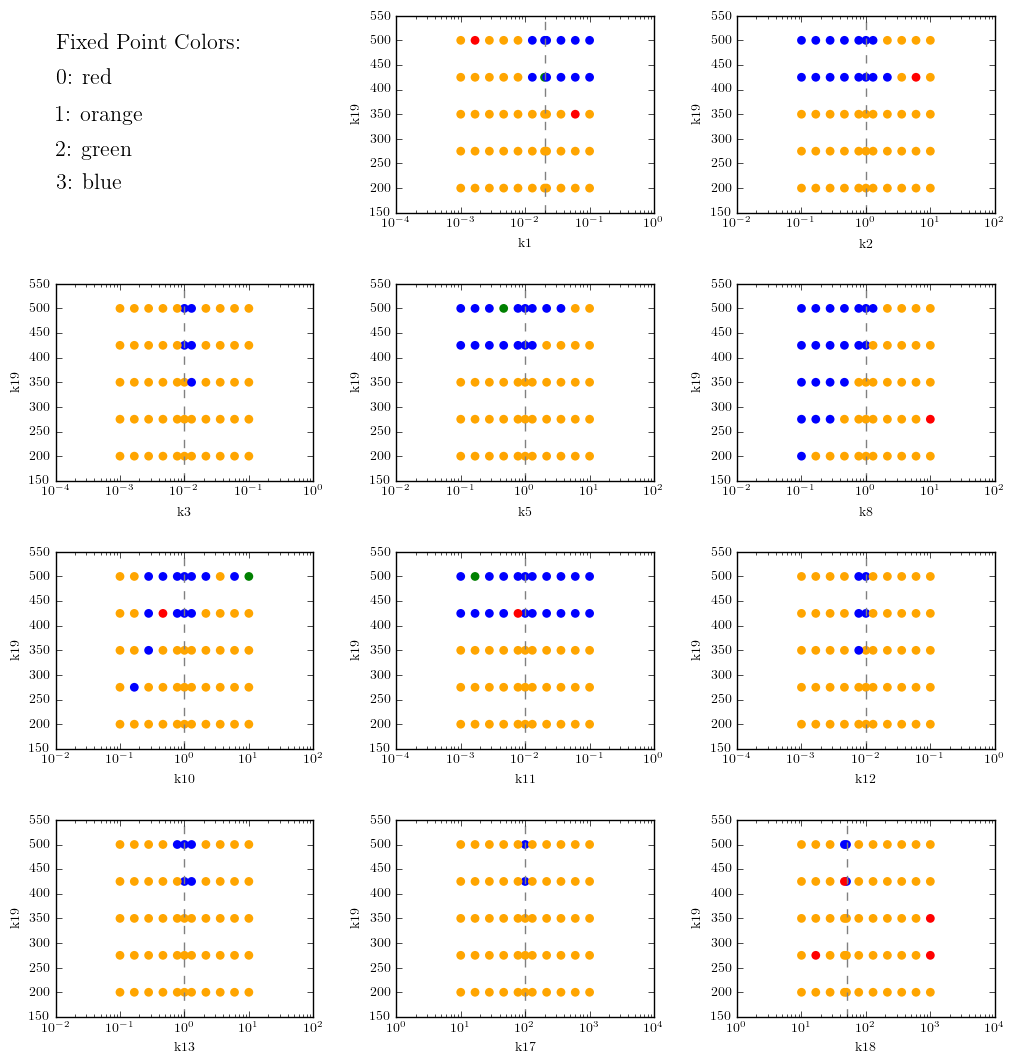

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(10.5, 11))

leg, *axes_i = axes.ravel()

leg.axis('off')
leg_t = "Fixed Point Color Map:\n{}".format('\n'.join('{}: {}'.format(k, v) for k, v in cd.items()))
leg.text(0, 0.5, leg_t, fontsize=16, verticalalignment='center', linespacing=2.0)

for k_i, ax in zip(parameters_to_mod, axes_i):
    filt = df['modified'] == k_i
    x = df.loc[filt, k_i]
    y = df.loc[filt, 'k19']
    fixed = df.loc[filt, 'color']
    
    ax.set_xlabel('{}'.format(k_i))
    ax.set_ylabel('k19')
    ax.set_xscale('log')
    ax.axvline(stock_constants[k_i], color='grey', linestyle='--')
    ax.scatter(x, y, c=fixed, lw=0, s=40)

plt.tight_layout(pad=2)
plt.show()

# Interpretation

- $k_8$, $k_{10}$, and $k_{12}$ showed weird states 
- $k_{12}$ and $k_{13}$ both sit on the side of cliffs
- $k_{17}$ and $k_{18}$ both have incredibly narrow margins in their ability to have 3 fixed points.
- $k_{11}$ and $k_{18}$ showed strange 0 fixed point state near solution for high $k_{19}$, which would result in chaotic system that could not attain equilibrium.
- $k_5$, $k_1$, and $k_2$ showed the highest robustness, but still had cliffs within the same order of magnitude.